# Evaluation of Automated Relevancy Classification

In [368]:
import pandas as pd
import re
import string
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
import krippendorff
from sklearn.preprocessing import LabelEncoder

In [426]:
chatgpt_relevancy = pd.read_csv('chatgpt_relevancy.csv')
mistral_relevancy = pd.read_csv('mistral_relevancy.csv')
openchat_relevancy = pd.read_csv('openchat_relevancy.csv')
claude_relevancy = pd.read_csv('claude_relevancy.csv')
vicuna_relevancy = pd.read_csv('vicuna_relevancy.csv')

In [427]:
vicuna_relevancy.loc[vicuna_relevancy.index[-135:], 'contextual_casual_similar'] = 'relevant'
vicuna_relevancy.loc[vicuna_relevancy.index[-257:], 'contextual_academic_similar'] = '1 relevant'

In [ ]:
print(len(chatgpt_relevancy), len(mistral_relevancy), len(openchat_relevancy), len(claude_relevancy), len(vicuna_relevancy))

### Cleaning the outputs
- formatting all teh LLMs responses to 3 categories: relevant, not relevant, can't say
- add 4th category can't determine for cases where an output is so inconsistent that the patterns cannot determine which of 3 above answers is given  

In [429]:
def extract_label(value):
    value = str(value).lower().strip()
    value = value.translate(str.maketrans('', '', string.punctuation))  

    # Define patterns to identify 'not relevant'
    not_relevant_patterns = [
        r'\bnot\s+relevant\b',         
        r'\b2\s+not\s+relevant\b'
        r'\bdiscard\b',                
        r'\bdo\s+not\s+consider\b',     
        r'\birrelevant\b',             
        r'\\answer:\s*2',              
        r'\\answer:\s*not\s+relevant', 
        r'\b2\b'                       
    ]

    # Define patterns to identify 'relevant'
    relevant_patterns = [
        r'\brelevant\b',               
        r'\bconsider\s+as\s+relevant\b',
        r'\\answer:\s*1',              
        r'\\answer:\s*relevant',       
        r'\b1\b'                       
    ]

    # Define patterns to identify 'can't say'
    cant_say_patterns = [
        r'\bcant\s+determine\b',       
        r'\bcannot\s+say\b',           
        r'\bnot\s+sure\b',             
        r'\bunknown\b',                
        r'\buncertain\b',              
        r'\b3\b'                       
    ]

    for pattern in not_relevant_patterns:
        if re.search(pattern, value):
            return 'not relevant'
    
    for pattern in cant_say_patterns:
        if re.search(pattern, value):
            return "can't say"
    
    for pattern in relevant_patterns:
        if re.search(pattern, value):
            return 'relevant'
    
    # If no patterns matched, return a default indication
    return "can't determine"

In [430]:
dfs = [chatgpt_relevancy, mistral_relevancy, openchat_relevancy, claude_relevancy, vicuna_relevancy]

def clean_llm_outputs(df, num_columns):
    # Select the last 8 columns
    relevant_columns = df.columns[-num_columns:]
    for col in relevant_columns:
        clean_col = df[col].apply(extract_label)
        new_col_name = f"{col}_clean"
        df[new_col_name] = clean_col

# Apply the cleaning process for each dataframe
for df in dfs:
    clean_llm_outputs(df, 8)

### Relevancy Classification Stats

In [431]:
column_names = [
    'zero_shot_clean', 
    'contextual_casual_similar_clean', 
    'contextual_academic_similar_clean', 
    'contextual_casual_diverse_clean', 
    'contextual_academic_diverse_clean', 
    'cot_clean', 
    'role_clean', 
    'emotional_clean'
]

# Function to calculate counts for each category by model and mode
def calculate_relevancy_stats(df, column_names):
    relevant_columns = df.columns[-len(column_names):]
    
    stats = {}

    for col, new_col_name in zip(relevant_columns, column_names):
        counts = df[col].value_counts()
        stats[new_col_name] = {
            'relevant': counts.get('relevant', 0),
            'not relevant': counts.get('not relevant', 0),
            "can't say": counts.get("can't say", 0),
            "can't determine": counts.get("can't determine", 0)
        }
        
    
    stats_df = pd.DataFrame(stats)
    return stats_df

In [432]:
# Apply the calculation for each dataframe and display the results
chatgpt_stats = calculate_relevancy_stats(chatgpt_relevancy, column_names)
mistral_stats = calculate_relevancy_stats(mistral_relevancy, column_names)
openchat_stats = calculate_relevancy_stats(openchat_relevancy, column_names)
claude_stats = calculate_relevancy_stats(claude_relevancy, column_names)
vicuna_stats = calculate_relevancy_stats(vicuna_relevancy, column_names)

In [433]:
chatgpt_stats.to_csv('chatgpt_stats.csv')
chatgpt_stats

,zero_shot_clean,contextual_casual_similar_clean,contextual_academic_similar_clean,contextual_casual_diverse_clean,contextual_academic_diverse_clean,cot_clean,role_clean,emotional_clean
relevant,653,2121,2082,1347,1284,255,407,1072
not relevant,1495,35,74,739,835,1900,1747,1073
can't say,2,0,0,2,2,0,0,3
can't determine,6,0,0,68,35,1,2,8


In [434]:
mistral_stats.to_csv('mistral_stats.csv')
mistral_stats

,zero_shot_clean,contextual_casual_similar_clean,contextual_academic_similar_clean,contextual_casual_diverse_clean,contextual_academic_diverse_clean,cot_clean,role_clean,emotional_clean
relevant,1697,2009,1983,2002,2011,1255,1476,2014
not relevant,464,59,84,152,145,908,687,146
can't say,1,4,5,2,1,1,2,5
can't determine,3,93,93,9,8,1,0,0


In [435]:
openchat_stats.to_csv('openchat_stats.csv')
openchat_stats

,zero_shot_clean,contextual_casual_similar_clean,contextual_academic_similar_clean,contextual_casual_diverse_clean,contextual_academic_diverse_clean,cot_clean,role_clean,emotional_clean
relevant,221,920,699,439,340,55,324,509
not relevant,1938,1242,1459,1720,1823,2108,1834,1651
can't say,6,3,7,5,2,2,6,4
can't determine,0,0,0,1,0,0,1,1


In [436]:
claude_stats.to_csv('claude_stats.csv')
claude_stats

,zero_shot_clean,contextual_casual_similar_clean,contextual_academic_similar_clean,contextual_casual_diverse_clean,contextual_academic_diverse_clean,cot_clean,role_clean,emotional_clean
relevant,291,1631,1682,912,771,59,142,303
not relevant,1870,487,439,1245,1387,2106,2023,1862
can't say,4,0,0,4,4,0,0,0
can't determine,0,47,44,4,3,0,0,0


In [437]:
vicuna_stats.to_csv('vicuna_stats.csv')
vicuna_stats

,zero_shot_clean,contextual_casual_similar_clean,contextual_academic_similar_clean,contextual_casual_diverse_clean,contextual_academic_diverse_clean,cot_clean,role_clean,emotional_clean
relevant,2085,1754,1782,2026,2005,2038,1969,2034
not relevant,78,411,383,116,135,127,190,128
can't say,0,0,0,1,1,0,0,0
can't determine,2,0,0,22,24,0,6,3


### Plot the classification counts

In [438]:
label_mapping = {
    'contextual_casual_similar_clean': 'contextual_\ncasual_\nsimilar',
    'contextual_academic_similar_clean': 'contextual_\nacademic_\nsimilar',
    'contextual_casual_diverse_clean': 'contextual_\ncasual_\ndiverse',
    'contextual_academic_diverse_clean': 'contextual_\nacademic_\ndiverse',
    'zero_shot_clean': 'zero_shot',
    'cot_clean': 'cot',
    'role_clean': 'role',
    'emotional_clean': 'emotional'
}

def map_labels(labels):
    return [label_mapping[label] for label in labels]

def create_stacked_bar_plot(stats_df, model_name):
    stats_df = stats_df.transpose()

    totals = stats_df.sum(axis=1)
    percentages = stats_df.divide(totals, axis=0) * 100

    viridis = plt.get_cmap('viridis', len(stats_df.columns))
    colors = viridis(np.linspace(0, 1, len(stats_df.columns)))

    x_labels = stats_df.index.tolist()
    x_positions = np.arange(len(x_labels))  

    fig, ax = plt.subplots(figsize=(10, 4))
    bottom = np.zeros(len(x_labels))  

    for i, category in enumerate(stats_df.columns):
        values = stats_df[category]
        ax.bar(x_positions, values, label=category, bottom=bottom, color=colors[i])
        bottom += values

    for i in range(len(x_positions)):
        cumulative_total = 0
        for j, category in enumerate(stats_df.columns):
            value = stats_df.iloc[i][category]
            percentage_value = percentages.iloc[i][category]
            if percentage_value > 2:  
                ax.text(x_positions[i], cumulative_total + value / 2, f'{percentage_value:.1f}%', 
                        ha='center', va='center', fontsize=8, color='white')
            cumulative_total += value

    ax.set_xticks(x_positions)
    mapped_labels = map_labels(x_labels)
    ax.set_xticklabels(mapped_labels, ha='center', fontsize=9)  

    plt.title(f'Relevancy Classification by {model_name}', fontsize=16)
    plt.ylabel('Counts', fontsize=12)  
    plt.xlabel('Mode', fontsize=12)

    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

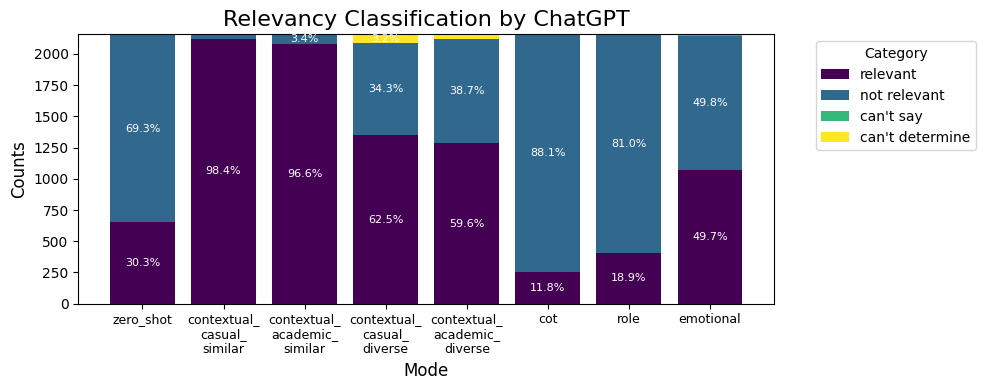

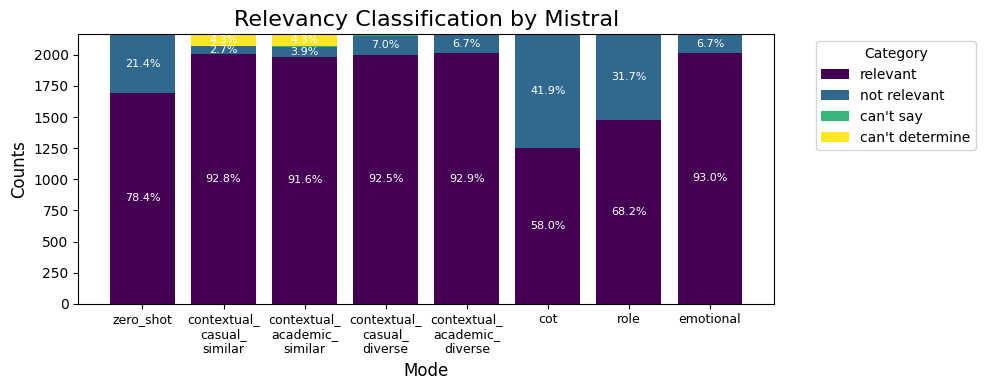

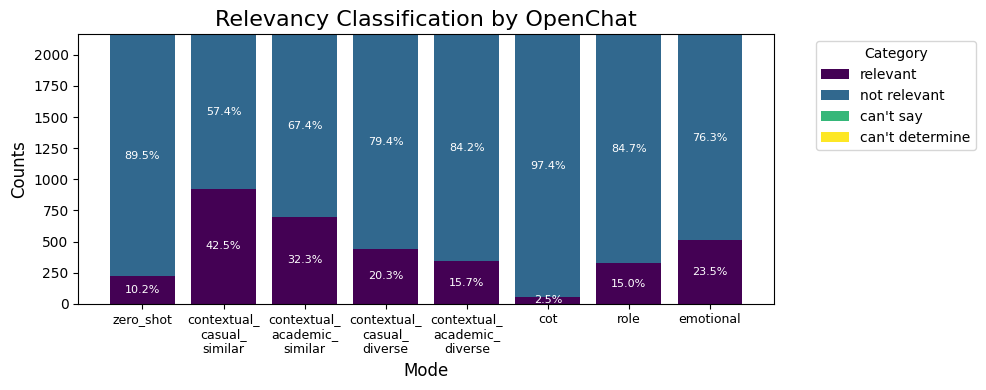

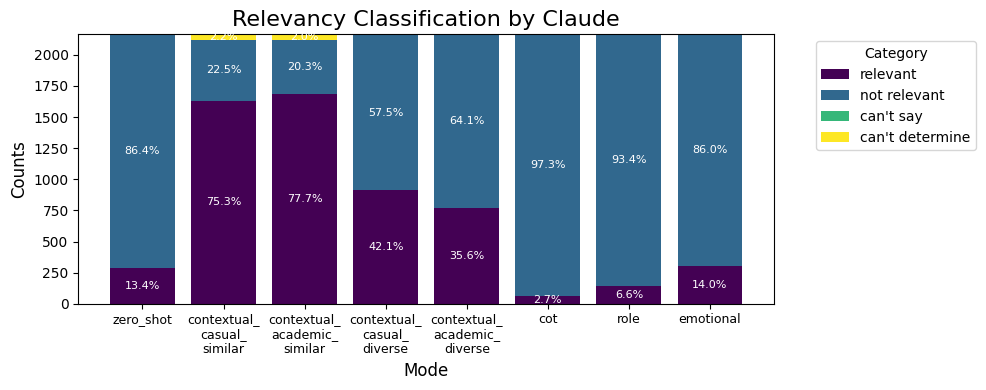

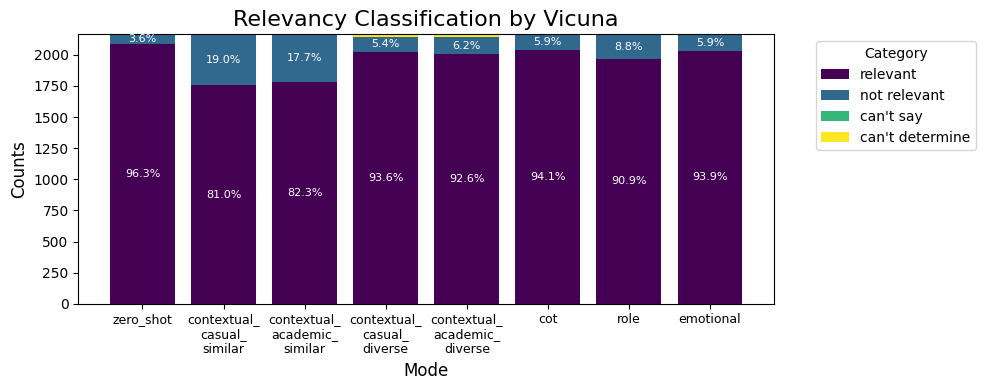

In [439]:
# Create stacked bar plots for each model
create_stacked_bar_plot(chatgpt_stats, "ChatGPT")
create_stacked_bar_plot(mistral_stats, "Mistral")
create_stacked_bar_plot(openchat_stats, "OpenChat")
create_stacked_bar_plot(claude_stats, "Claude")
create_stacked_bar_plot(vicuna_stats, "Vicuna")

### Evaluation metrics

In [440]:
# Define the compute_metrics function
def compute_metrics(df, column):
    y_true = df['manual_label']
    y_pred = df[column]
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    precision = round(precision, 3)
    recall = round(recall, 3)
    f1 = round(f1, 3)
    return accuracy, precision, recall, f1

# Initialize the metrics dictionary with the modes
metrics = {
    'Mode': [
        'Mode 1: zero-shot', 
        'Mode 2: contextual_casual_similar', 
        'Mode 3: contextual_academic_similar',
        'Mode 4: contextual_casual_diverse', 
        'Mode 5: contextual_academic_diverse', 
        'Mode 6: cot',
        'Mode 7: role', 
        'Mode 8: emotional'
    ],
    'ChatGPT_F1': [],
    'Mistral_F1': [],
    'OpenChat_F1': [],
    'Claude_F1': [],
    'Vicuna_F1': [],
    'ChatGPT_Accuracy': [],
    'Mistral_Accuracy': [],
    'OpenChat_Accuracy': [],
    'Claude_Accuracy': [],
    'Vicuna_Accuracy': [],
    'ChatGPT_Precision': [],
    'Mistral_Precision': [],
    'OpenChat_Precision': [],
    'Claude_Precision': [],
    'Vicuna_Precision': [],
    'ChatGPT_Recall': [],
    'Mistral_Recall': [],
    'OpenChat_Recall': [],
    'Claude_Recall': [],
    'Vicuna_Recall': []
}

# Relevant columns mapped to modes for each model
modes = [
    'zero_shot_clean', 
    'contextual_casual_similar_clean', 
    'contextual_academic_similar_clean',
    'contextual_casual_diverse_clean', 
    'contextual_academic_diverse_clean', 
    'cot_clean',
    'role_clean', 
    'emotional_clean'
]

for mode, column in zip(metrics['Mode'], modes):
    # ChatGPT metrics
    accuracy, precision, recall, f1 = compute_metrics(chatgpt_relevancy, column)
    metrics['ChatGPT_Accuracy'].append(accuracy)
    metrics['ChatGPT_Precision'].append(precision)
    metrics['ChatGPT_Recall'].append(recall)
    metrics['ChatGPT_F1'].append(f1)
    
    # Mistral metrics
    accuracy, precision, recall, f1 = compute_metrics(mistral_relevancy, column)
    metrics['Mistral_Accuracy'].append(accuracy)
    metrics['Mistral_Precision'].append(precision)
    metrics['Mistral_Recall'].append(recall)
    metrics['Mistral_F1'].append(f1)
    
    # OpenChat metrics
    accuracy, precision, recall, f1 = compute_metrics(openchat_relevancy, column)
    metrics['OpenChat_Accuracy'].append(accuracy)
    metrics['OpenChat_Precision'].append(precision)
    metrics['OpenChat_Recall'].append(recall)
    metrics['OpenChat_F1'].append(f1)

    # Claude metrics
    accuracy, precision, recall, f1 = compute_metrics(claude_relevancy, column)
    metrics['Claude_Accuracy'].append(accuracy)
    metrics['Claude_Precision'].append(precision)
    metrics['Claude_Recall'].append(recall)
    metrics['Claude_F1'].append(f1)

    # Vicuna metrics
    accuracy, precision, recall, f1 = compute_metrics(vicuna_relevancy, column)
    metrics['Vicuna_Accuracy'].append(accuracy)
    metrics['Vicuna_Precision'].append(precision)
    metrics['Vicuna_Recall'].append(recall)
    metrics['Vicuna_F1'].append(f1)

# Convert the metrics dictionary into a DataFrame
relevancy_stats = pd.DataFrame(metrics)

# Display the metrics DataFrame
relevancy_stats.to_csv('relevancy_stats.csv', index = False)
relevancy_stats

,Mode,ChatGPT_F1,Mistral_F1,OpenChat_F1,Claude_F1,Vicuna_F1,ChatGPT_Accuracy,Mistral_Accuracy,OpenChat_Accuracy,Claude_Accuracy,...,ChatGPT_Precision,Mistral_Precision,OpenChat_Precision,Claude_Precision,Vicuna_Precision,ChatGPT_Recall,Mistral_Recall,OpenChat_Recall,Claude_Recall,Vicuna_Recall
0,Mode 1: zero-shot,0.255,0.122,0.433,0.395,0.052,0.711,0.265,0.897,0.861,...,0.273,0.265,0.413,0.383,0.336,0.346,0.302,0.480,0.450,0.335
1,Mode 2: contextual_casual_similar,0.064,0.039,0.303,0.163,0.205,0.065,0.077,0.603,0.266,...,0.483,0.259,0.359,0.346,0.505,0.494,0.248,0.457,0.372,0.519
2,Mode 3: contextual_academic_similar,0.084,0.045,0.336,0.154,0.191,0.084,0.088,0.696,0.248,...,0.513,0.258,0.364,0.349,0.497,0.509,0.249,0.468,0.377,0.491
3,Mode 4: contextual_casual_diverse,0.162,0.058,0.288,0.233,0.049,0.379,0.116,0.809,0.612,...,0.262,0.252,0.285,0.273,0.260,0.298,0.252,0.364,0.362,0.261
4,Mode 5: contextual_academic_diverse,0.173,0.058,0.396,0.250,0.052,0.419,0.115,0.847,0.673,...,0.261,0.257,0.385,0.276,0.252,0.298,0.258,0.471,0.368,0.253
5,Mode 6: cot,0.411,0.188,0.369,0.637,0.095,0.880,0.461,0.933,0.945,...,0.395,0.267,0.390,0.700,0.486,0.464,0.333,0.361,0.607,0.483
6,Mode 7: role,0.374,0.210,0.307,0.640,0.084,0.813,0.363,0.857,0.920,...,0.372,0.354,0.295,0.627,0.338,0.452,0.423,0.366,0.657,0.343
7,Mode 8: emotional,0.207,0.079,0.281,0.580,0.066,0.531,0.119,0.782,0.854,...,0.267,0.350,0.283,0.566,0.333,0.332,0.354,0.369,0.660,0.333


In [441]:
def compute_mean_sd(df, column):
    y_true = df['manual_label']
    y_pred = df[column]
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return accuracy, precision, recall, f1

# Initialize dictionaries to store mean and SD for each LLM
avg_metrics = {
    'LLM': ['ChatGPT', 'Mistral', 'OpenChat', 'Claude', 'Vicuna'],
    'F1': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': []
}

# Define a function to calculate mean and standard deviation and format results
def calculate_average_metrics(llm_data, modes):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for column in modes:
        accuracy, precision, recall, f1 = compute_mean_sd(llm_data, column)
        f1_scores.append(f1)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        
    # Compute mean and standard deviation
    accuracy_mean, accuracy_sd = np.mean(accuracies), np.std(accuracies)
    precision_mean, precision_sd = np.mean(precisions), np.std(precisions)
    recall_mean, recall_sd = np.mean(recalls), np.std(recalls)
    f1_mean, f1_sd = np.mean(f1_scores), np.std(f1_scores)
    
    # Format each metric as 'mean (+/- SD)' with three decimal places
    avg_metrics['F1'].append(f"{f1_mean:.3f} (+/- {f1_sd:.2f})")
    avg_metrics['Accuracy'].append(f"{accuracy_mean:.3f} (+/- {accuracy_sd:.2f})")
    avg_metrics['Precision'].append(f"{precision_mean:.3f} (+/- {precision_sd:.2f})")
    avg_metrics['Recall'].append(f"{recall_mean:.3f} (+/- {recall_sd:.2f})")

# Compute metrics for each LLM
modes = ['zero_shot_clean', 'contextual_casual_similar_clean', 'contextual_academic_similar_clean',
         'contextual_casual_diverse_clean', 'contextual_academic_diverse_clean', 'cot_clean',
         'role_clean', 'emotional_clean']

# Apply to each LLM dataset
calculate_average_metrics(chatgpt_relevancy, modes)
calculate_average_metrics(mistral_relevancy, modes)
calculate_average_metrics(openchat_relevancy, modes)
calculate_average_metrics(claude_relevancy, modes)
calculate_average_metrics(vicuna_relevancy, modes)

# Convert the results to a DataFrame
average_results_df = pd.DataFrame(avg_metrics)

# Display the formatted DataFrame with means and standard deviations
average_results_df.to_csv('models_performance.csv', index = False)
average_results_df

,LLM,F1,Accuracy,Precision,Recall
0,ChatGPT,0.216 (+/- 0.12),0.485 (+/- 0.29),0.353 (+/- 0.10),0.399 (+/- 0.08)
1,Mistral,0.100 (+/- 0.06),0.200 (+/- 0.14),0.283 (+/- 0.04),0.302 (+/- 0.06)
2,OpenChat,0.339 (+/- 0.05),0.803 (+/- 0.10),0.347 (+/- 0.05),0.417 (+/- 0.05)
3,Claude,0.381 (+/- 0.20),0.672 (+/- 0.26),0.440 (+/- 0.16),0.482 (+/- 0.13)
4,Vicuna,0.099 (+/- 0.06),0.128 (+/- 0.05),0.376 (+/- 0.10),0.377 (+/- 0.10)


### Overall F1 scores

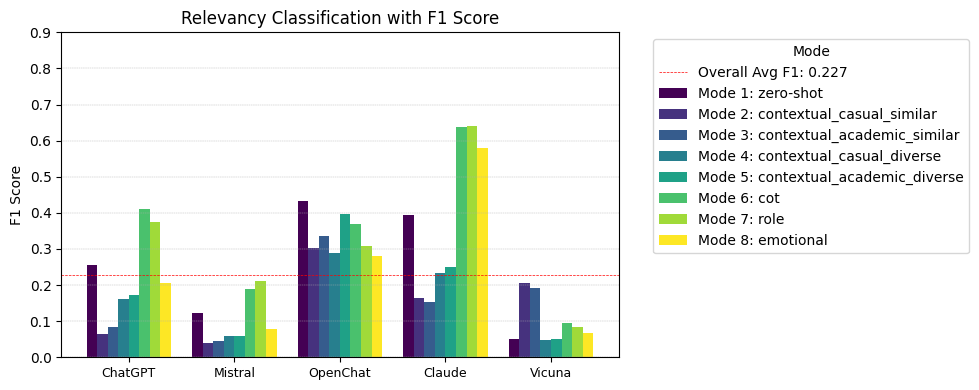

In [442]:
def plot_f1_scores_by_model(df):
    models = ['ChatGPT_F1', 'Mistral_F1', 'OpenChat_F1', 'Claude_F1', 'Vicuna_F1'] 
    modes = df['Mode']  

    # Set the positions and width for the bars
    bar_width = 0.15
    num_models = len(models)
    num_modes = len(modes)
    
    # Add extra space between model groups
    spacing = 0.3  #

    # Create positions with space between groups
    positions = np.arange(num_models) * (num_modes * bar_width + spacing)

    # Use the viridis colormap for coloring
    viridis = plt.get_cmap('viridis', num_modes)
    colors = viridis(np.linspace(0, 1, num_modes))

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot bars for each mode within each model
    for i, mode in enumerate(modes):
        ax.bar(positions + i * bar_width, df[[model for model in models]].iloc[i], 
               bar_width, label=mode, color=colors[i])

    # Set the model labels as xticks
    ax.set_xticks(positions + (num_modes - 1) * bar_width / 2)
    ax.set_xticklabels([model.split('_')[0] for model in models], fontsize=9)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.3)
    ax.set_yticks(np.arange(0, 1, 0.1))
    overall_avg_f1 = df[models].mean().mean()
    ax.axhline(overall_avg_f1, color='red', linestyle='--', linewidth=0.5, label=f'Overall Avg F1: {overall_avg_f1:.3f}')

    ax.set_ylabel('F1 Score')
    ax.set_title('Relevancy Classification with F1 Score')
    
    ax.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_f1_scores_by_model(relevancy_stats)

### Detailed metrics overview by model

In [443]:
def plot_metrics_by_model(df):
    # Models to plot
    models = ['ChatGPT', 'Mistral', 'OpenChat', 'Claude', 'Vicuna']
    metrics = ['F1', 'Accuracy', 'Precision', 'Recall']  
    modes = df['Mode']  

    bar_width = 0.2
    num_modes = len(modes)
    
    viridis = plt.get_cmap('viridis', num_modes)
    colors = viridis(np.linspace(0, 1, num_modes))

    for model in models:
        fig, ax = plt.subplots(figsize=(8, 4))
        
        positions = np.arange(len(metrics)) * (num_modes * bar_width + 0.3)

        # Plot each mode for the current model
        for i, mode in enumerate(modes):
            metric_values = [
                df[f'{model}_F1'].iloc[i],
                df[f'{model}_Accuracy'].iloc[i],
                df[f'{model}_Precision'].iloc[i],
                df[f'{model}_Recall'].iloc[i]
            ]
            ax.bar(positions + i * bar_width, metric_values, bar_width, label=mode, color=colors[i])

        ax.set_xticks(positions + (num_modes - 1) * bar_width / 2)
        ax.set_yticks(np.arange(0, 1, 0.1))
        ax.set_xticklabels(metrics, fontsize=9)

        ax.set_ylabel('Score')
        ax.set_title(f'{model}: F1, Accuracy, Precision and Recall')
        ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.3)
        ax.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)  # Smaller legend

        plt.tight_layout()
        plt.show()

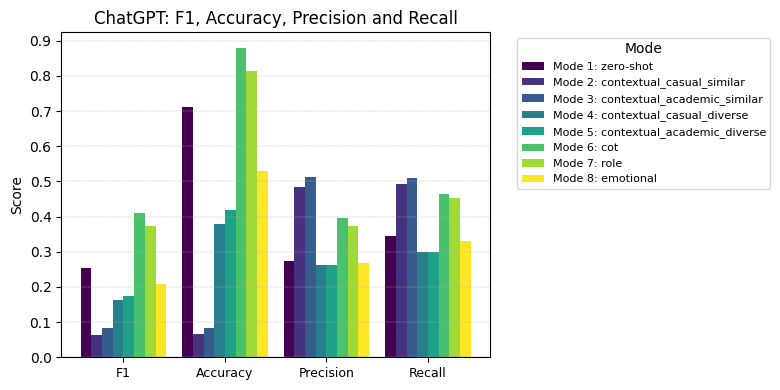

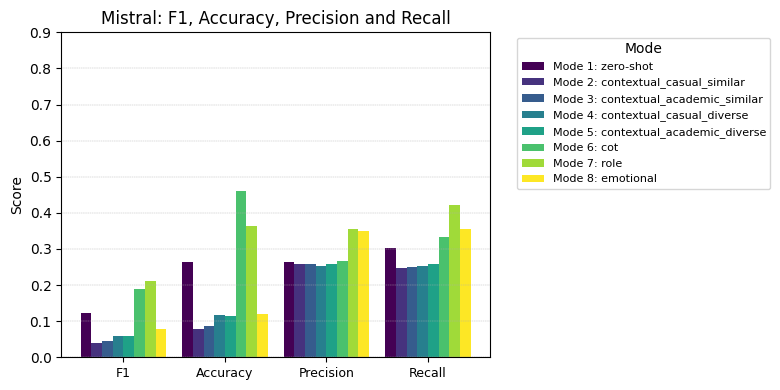

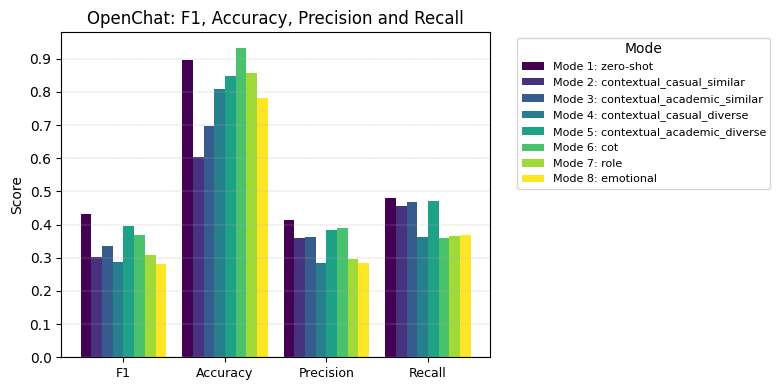

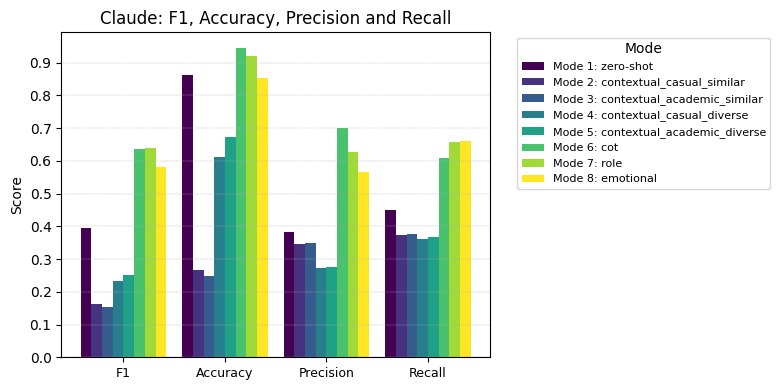

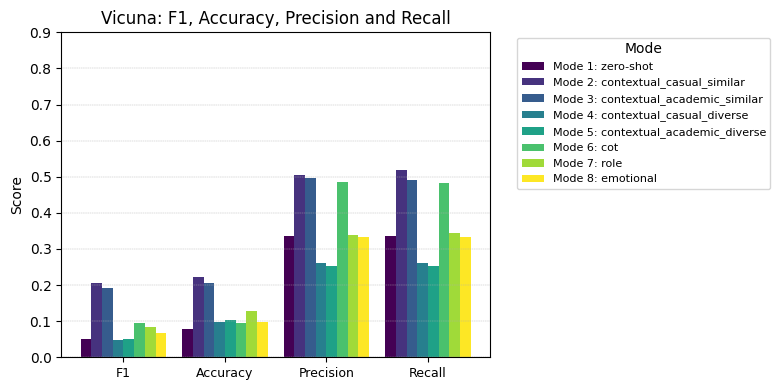

In [444]:
plot_metrics_by_model(relevancy_stats)

## By Prompting Strategy

In [445]:
prompting_average = {
    'Mode': relevancy_stats['Mode'],
    'F1 Score': relevancy_stats[['ChatGPT_F1', 'Mistral_F1', 'OpenChat_F1', 'Claude_F1', 'Vicuna_F1']].mean(axis=1),
    'Accuracy': relevancy_stats[['ChatGPT_Accuracy', 'Mistral_Accuracy', 'OpenChat_Accuracy', 'Claude_Accuracy', 'Vicuna_Accuracy']].mean(axis=1),
    'Precision': relevancy_stats[['ChatGPT_Precision', 'Mistral_Precision', 'OpenChat_Precision', 'Claude_Precision', 'Vicuna_Precision']].mean(axis=1),
    'Recall': relevancy_stats[['ChatGPT_Recall', 'Mistral_Recall', 'OpenChat_Recall', 'Claude_Recall', 'Vicuna_Recall']].mean(axis=1)
}

prompting_average_df = pd.DataFrame(prompting_average)
prompting_average_df = prompting_average_df.round(3)
prompting_average_df.to_csv('prompting_performance.csv', index = False)
prompting_average_df

,Mode,F1 Score,Accuracy,Precision,Recall
0,Mode 1: zero-shot,0.251,0.563,0.334,0.383
1,Mode 2: contextual_casual_similar,0.155,0.246,0.390,0.418
2,Mode 3: contextual_academic_similar,0.162,0.264,0.396,0.419
3,Mode 4: contextual_casual_diverse,0.158,0.403,0.266,0.307
4,Mode 5: contextual_academic_diverse,0.186,0.431,0.286,0.330
5,Mode 6: cot,0.340,0.663,0.448,0.450
6,Mode 7: role,0.323,0.616,0.397,0.448
7,Mode 8: emotional,0.243,0.477,0.360,0.410


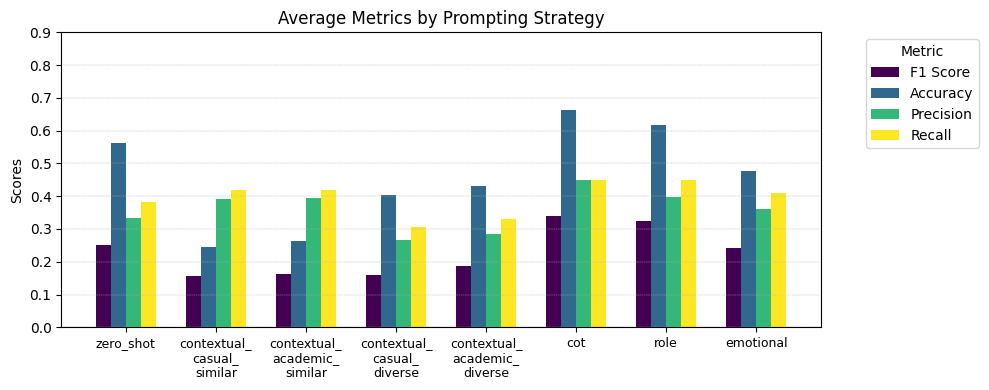

In [447]:
# Label mapping dictionary
label_mapping = {
    'Mode 1: zero-shot': 'zero_shot',
    'Mode 2: contextual_casual_similar': 'contextual_\ncasual_\nsimilar',
    'Mode 3: contextual_academic_similar': 'contextual_\nacademic_\nsimilar',
    'Mode 4: contextual_casual_diverse': 'contextual_\ncasual_\ndiverse',
    'Mode 5: contextual_academic_diverse': 'contextual_\nacademic_\ndiverse',
    'Mode 6: cot': 'cot',
    'Mode 7: role': 'role',
    'Mode 8: emotional': 'emotional'
}

# Function to map the original labels to their manually specified divisions
def map_labels(labels):
    return [label_mapping[label] for label in labels]

def plot_metrics_by_mode(df):
    metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall']
    modes = df['Mode']
    mapped_modes = map_labels(modes)

    bar_width = 0.15
    num_metrics = len(metrics)
    num_modes = len(modes)
    spacing = 0.3

    positions = np.arange(num_modes) * (num_metrics * bar_width + spacing)

    viridis = plt.get_cmap('viridis', num_metrics)
    colors = viridis(np.linspace(0, 1, num_metrics))

    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot bars for each metric within each mode
    for i, metric in enumerate(metrics):
        ax.bar(positions + i * bar_width, df[metric], bar_width, label=metric, color=colors[i])

    ax.set_xticks(positions + (num_metrics - 1) * bar_width / 2)
    ax.set_xticklabels(mapped_modes, fontsize=9)

    ax.set_ylabel('Scores')
    ax.set_title('Average Metrics by Prompting Strategy')

    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.3)

    ax.set_yticks(np.arange(0, 1, 0.1))
    ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_metrics_by_mode(prompting_average_df)


## Annotator Agreement: Krippendorff’s Alpha

In [448]:
# Define the prompt columns
prompt_columns = [
    'zero_shot_clean', 
    'contextual_casual_similar_clean', 
    'contextual_academic_similar_clean',
    'contextual_casual_diverse_clean', 
    'contextual_academic_diverse_clean', 
    'cot_clean',
    'role_clean', 
    'emotional_clean'
]

def encode_labels(df, columns):
    """Encode string labels to numeric categories for each prompt column."""
    encoder = LabelEncoder()
    for column in columns:
        df[column] = encoder.fit_transform(df[column].astype(str))  
    return df

# Apply label encoding to each model's dataset
chatgpt_relevancy = encode_labels(chatgpt_relevancy, prompt_columns)
mistral_relevancy = encode_labels(mistral_relevancy, prompt_columns)
openchat_relevancy = encode_labels(openchat_relevancy, prompt_columns)
claude_relevancy = encode_labels(claude_relevancy, prompt_columns)
vicuna_relevancy = encode_labels(vicuna_relevancy, prompt_columns)

# Ensure that all DataFrames have the same number of rows by aligning on the index
common_index = chatgpt_relevancy.index.intersection(mistral_relevancy.index)
common_index = common_index.intersection(openchat_relevancy.index)
common_index = common_index.intersection(claude_relevancy.index)
common_index = common_index.intersection(vicuna_relevancy.index)

# Filter each DataFrame to only keep the common index (rows present in all models)
chatgpt_relevancy = chatgpt_relevancy.loc[common_index]
mistral_relevancy = mistral_relevancy.loc[common_index]
openchat_relevancy = openchat_relevancy.loc[common_index]
claude_relevancy = claude_relevancy.loc[common_index]
vicuna_relevancy = vicuna_relevancy.loc[common_index]

# Combine the prompt columns for all models into a single DataFrame
all_model_relevancy = pd.DataFrame({
    'chatgpt': chatgpt_relevancy[prompt_columns].values.tolist(),
    'mistral': mistral_relevancy[prompt_columns].values.tolist(),
    'openchat': openchat_relevancy[prompt_columns].values.tolist(),
    'claude': claude_relevancy[prompt_columns].values.tolist(),
    'vicuna': vicuna_relevancy[prompt_columns].values.tolist()
})

# Convert the DataFrame to a NumPy array and stack the prompt columns for all models
data_across_models = np.vstack([
    chatgpt_relevancy[prompt_columns].values,
    mistral_relevancy[prompt_columns].values,
    openchat_relevancy[prompt_columns].values,
    claude_relevancy[prompt_columns].values,
    vicuna_relevancy[prompt_columns].values
])

alpha_across_models = krippendorff.alpha(reliability_data=data_across_models, level_of_measurement='nominal')
print(f"Krippendorff's Alpha (Across Models & Prompts): {alpha_across_models:.3f}")


Krippendorff's Alpha (Across Models & Prompts): 0.162


### Across Models (per prompt)

In [449]:
# Function to calculate Krippendorff's Alpha across models for each prompt
def calculate_alpha_across_models_per_prompt(prompt_column):
    """Calculate Krippendorff's Alpha for a specific prompt across models."""
    # Combine the prompt classifications from all models
    prompt_data = np.vstack([
        chatgpt_relevancy[prompt_column].values,
        mistral_relevancy[prompt_column].values,
        openchat_relevancy[prompt_column].values,
        claude_relevancy[prompt_column].values,
        vicuna_relevancy[prompt_column].values
    ])
    
    # Transpose the array to match papers x models structure
    prompt_data = prompt_data.T
    
    # Calculate Krippendorff's Alpha for the prompt
    alpha_value = krippendorff.alpha(reliability_data=prompt_data, level_of_measurement='nominal')
    return alpha_value

# Calculate Krippendorff's Alpha for each prompt
alpha_results = {}
for prompt in prompt_columns:
    alpha = calculate_alpha_across_models_per_prompt(prompt)
    alpha_results[prompt] = round(alpha, 3)

# Optionally, print the results as a table
alpha_df = pd.DataFrame(list(alpha_results.items()), columns=['Prompt', "Krippendorff's Alpha"])
alpha_df

,Prompt,Krippendorff's Alpha
0,zero_shot_clean,0.610
1,contextual_casual_similar_clean,0.575
2,contextual_academic_similar_clean,0.581
3,contextual_casual_diverse_clean,0.344
4,contextual_academic_diverse_clean,0.491
5,cot_clean,0.702
6,role_clean,0.586
7,emotional_clean,0.512


- Top 2 agreeing models per prompt

In [450]:
def calculate_krippendorff_alpha(df1, df2, prompt_column):
    classifications_1 = df1[prompt_column].values
    classifications_2 = df2[prompt_column].values
    
    prompt_data = np.vstack([classifications_1, classifications_2])
    
    prompt_data = prompt_data.T
    alpha_value = krippendorff.alpha(reliability_data=prompt_data, level_of_measurement='nominal')
    return alpha_value

# Function to find the top aligned model pair for each prompt
def find_top_aligned_models(models, prompt_columns):
    alignment_results = {}

    for prompt in prompt_columns:
        pairwise_alphas = []

        # Calculate Krippendorff's Alpha for each pair of models
        model_names = list(models.keys())
        for i in range(len(model_names)):
            for j in range(i+1, len(model_names)):
                model1 = model_names[i]
                model2 = model_names[j]
                
                alpha = calculate_krippendorff_alpha(models[model1], models[model2], prompt)
                pairwise_alphas.append((model1, model2, alpha))
        
        # Sort pairs by the Krippendorff's Alpha value (highest agreement first)
        pairwise_alphas.sort(key=lambda x: x[2], reverse=True)

        # Store the top aligned model pair for the prompt
        alignment_results[prompt] = {
            'Top Aligned Models': f"{pairwise_alphas[0][0]} & {pairwise_alphas[0][1]}",
            'Krippendorff\'s Alpha': round(pairwise_alphas[0][2], 3)
        }

    return pd.DataFrame(alignment_results).T

models = {
    'ChatGPT': chatgpt_relevancy,
    'Mistral': mistral_relevancy,
    'OpenChat': openchat_relevancy,
    'Claude': claude_relevancy,
    'Vicuna': vicuna_relevancy
}

alignment_df = find_top_aligned_models(models, prompt_columns)
alignment_df.reset_index(inplace=True)
alignment_df.columns = ['Prompt', 'Top Aligned Models', "Krippendorff's Alpha"]
alignment_df


,Prompt,Top Aligned Models,Krippendorff's Alpha
0,zero_shot_clean,OpenChat & Vicuna,0.743
1,contextual_casual_similar_clean,ChatGPT & Mistral,0.844
2,contextual_academic_similar_clean,ChatGPT & Mistral,0.797
3,contextual_casual_diverse_clean,OpenChat & Vicuna,0.55
4,contextual_academic_diverse_clean,Mistral & OpenChat,0.665
5,cot_clean,OpenChat & Claude,0.899
6,role_clean,Claude & Vicuna,0.748
7,emotional_clean,Claude & Vicuna,0.698


### Across Prompts (per model)

In [451]:
# Function to calculate Krippendorff's Alpha across prompts for each model
def calculate_alpha_across_prompts_for_model(model_df):
    """Calculate Krippendorff's Alpha for a model across all prompts."""
    prompt_data = model_df[prompt_columns].values
    prompt_data = prompt_data.T
    
    # Calculate Krippendorff's Alpha for the model across prompts
    alpha_value = krippendorff.alpha(reliability_data=prompt_data, level_of_measurement='nominal')
    return round(alpha_value, 3)

# Calculate Krippendorff's Alpha for each model across prompts
alpha_per_model = {}
alpha_per_model['ChatGPT'] = calculate_alpha_across_prompts_for_model(chatgpt_relevancy)
alpha_per_model['Mistral'] = calculate_alpha_across_prompts_for_model(mistral_relevancy)
alpha_per_model['OpenChat'] = calculate_alpha_across_prompts_for_model(openchat_relevancy)
alpha_per_model['Claude'] = calculate_alpha_across_prompts_for_model(claude_relevancy)
alpha_per_model['Vicuna'] = calculate_alpha_across_prompts_for_model(vicuna_relevancy)

alpha_df = pd.DataFrame(list(alpha_per_model.items()), columns=['Model', "Krippendorff's Alpha"])
alpha_df


,Model,Krippendorff's Alpha
0,ChatGPT,-0.027
1,Mistral,-0.054
2,OpenChat,-0.032
3,Claude,-0.063
4,Vicuna,-0.108
